In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from statsmodels.tsa.deterministic import DeterministicProcess

## Generate perfect daily-weekly pattern

Text(0, 0.5, 'full')

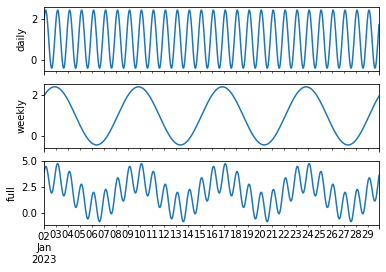

In [2]:
date_range = pd.date_range(start='2023-01-02', periods=24*28, freq='H')

daily_proc = DeterministicProcess(date_range, constant=True, period=24, fourier=1).in_sample().to_numpy()
daily = pd.Series(np.sum(daily_proc,axis=1), index=date_range)

weekly_proc = DeterministicProcess(date_range, constant=True, period=7*24, fourier=1).in_sample().to_numpy()
weekly = pd.Series(np.sum(weekly_proc,axis=1), index=date_range)


full_proc = np.sum(daily_proc + weekly_proc,axis=1)
full = pd.Series(full_proc, index=date_range)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

daily.plot(ax=ax1)
weekly.plot(ax=ax2)
full.plot(ax=ax3)

ax1.set_ylabel('daily')
ax2.set_ylabel('weekly')
ax3.set_ylabel('full')

In [3]:
def gen_weekly_daily(num_weeks=4, start_date='2023-01-02'):
    date_range = pd.date_range(start=start_date, periods=24*7*num_weeks, freq='H')

    daily_proc = DeterministicProcess(date_range, constant=True, period=24, fourier=1).in_sample().to_numpy()
    daily = pd.Series(np.sum(daily_proc,axis=1), index=date_range)

    weekly_proc = DeterministicProcess(date_range, constant=True, period=7*24, fourier=1).in_sample().to_numpy()
    weekly = pd.Series(np.sum(weekly_proc,axis=1), index=date_range)


    full_proc = np.sum(daily_proc + weekly_proc,axis=1)
    full = pd.Series(full_proc, index=date_range)
    return full

In [4]:
full = gen_weekly_daily(num_weeks=4, start_date='2023-01-02')

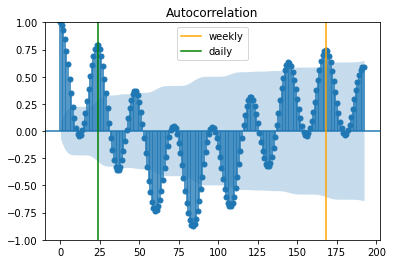

In [5]:
sm.graphics.tsa.plot_acf(full.values.squeeze(), lags=24*8)
plt.axvline(168,label="weekly", color='orange')
plt.axvline(24,label="daily", color='green')
plt.legend()
plt.show()

In [6]:
def get_pivoted(full):
    df = pd.DataFrame(full)
    df["updatetime"]  = full.index
    df["week_start"] = df["updatetime"].dt.to_period('W-SUN').apply(lambda r: r.start_time)
    df["tow"] = df['updatetime'] - df['week_start']
    pivoted = pd.pivot_table(df, values = 0, index=['week_start'], columns = 'tow').reset_index()
    return pivoted.replace(-666,np.nan)

<Figure size 432x288 with 0 Axes>

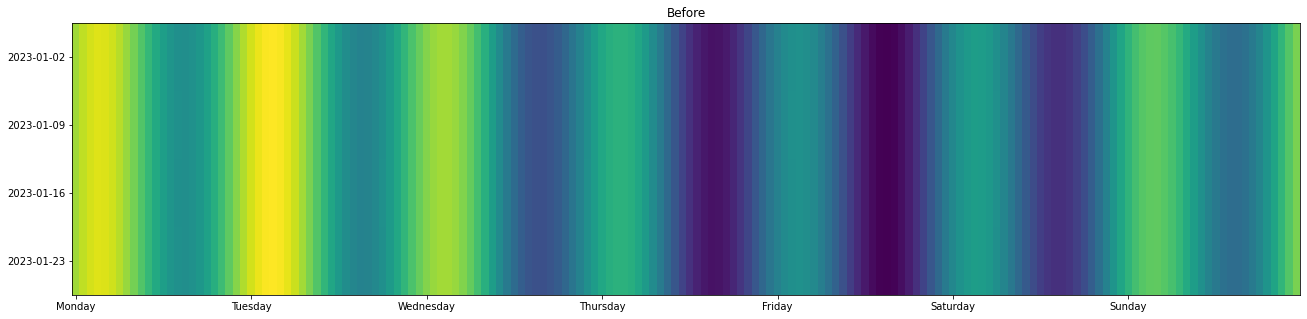

<Figure size 432x288 with 0 Axes>

In [7]:
fig, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(22, 5))
pivoted = get_pivoted(full)
ax1.imshow(pivoted.iloc[:,1:], aspect='auto')
ax1.set_title('Before')
ax1.set_xticks(list(range(0,168,24)),["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
ax1.set_yticks(list(pivoted.iloc[::1].index),list(pivoted.iloc[::1].week_start.apply(lambda x: x.strftime('%Y-%m-%d'))))
plt.figure()

## Generate random missing data patterns

In [8]:
def uniform_random_missing_patterns(arr, num_patterns=100, num_missings=30):
    patterns = []
    if arr.shape[1] != 168:
        print("INFO: row size expected to be number of hours in a week (168)")
    for i in range(num_patterns):
        mask = np.zeros_like(arr)
        rows = np.random.randint(0, mask.shape[0],num_missings)
        cols = np.random.randint(0, mask.shape[1],num_missings)
        
        indexarray = np.array([rows,cols])
        rows, cols = indexarray[0], indexarray[1]


        mask[rows, cols] = 1

        patterns.append(mask)
    return patterns

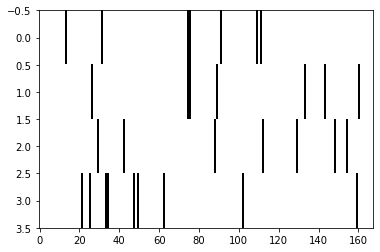

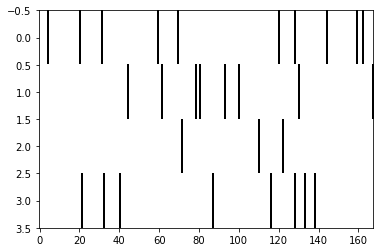

<Figure size 432x288 with 0 Axes>

In [9]:
patterns = uniform_random_missing_patterns(pivoted.iloc[:,1:], num_patterns=2)
for pat in patterns:
    plt.imshow(pat, aspect='auto', cmap='binary', interpolation='nearest')
    plt.figure()